# Multidimensional Scaling (MSD)
### Pisani (2016)
Esta libreta busca reproducir el trabajo de Pisani (2016): *Molecular Dynamics Simulations and Classical Multidimensional Scaling Unveil New Metastable States in the Conformational Landscape of CDK2*.

In [1]:
from prody import *
from pylab import *
import pandas as pd

/home/joel/anaconda3/envs/mds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Lo primero es elegir las **255** estructuras que los autores usaron para el análisis con el criterio de haber usado sólo estructuras con **resolución igual o menor a 2.5 A**, y que **tuvieran todos los residuos** de la siguiente lista posiciones.
  
#### Residuos de Pisani (2016).

In [11]:
from itertools import chain
pisiani_rangeResidues = [ [4,12], [17, 24], [29,34], [46,55], [66,71], [76,81],  
                         [87,93], [101, 120], [121, 135], [140, 150], [182, 194], [277, 282]]
lista = [list( range(valor[0], valor[1] + 1) ) for valor in pisiani_rangeResidues]
# Se obtiene la lista de residuos, incluida en formato de cadena de texto
pisiani_residues = list(chain.from_iterable(lista))
pisiani_residues_str = ' '.join(str(e) for e in pisiani_residues)
print(pisiani_residues_str)
print(len(pisiani_residues))

4 5 6 7 8 9 10 11 12 17 18 19 20 21 22 23 24 29 30 31 32 33 34 46 47 48 49 50 51 52 53 54 55 66 67 68 69 70 71 76 77 78 79 80 81 87 88 89 90 91 92 93 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 140 141 142 143 144 145 146 147 148 149 150 182 183 184 185 186 187 188 189 190 191 192 193 194 277 278 279 280 281 282
117


In [14]:
from Funciones.subsecuencias_cdk2 import get_ricci_residues, get_pisani_residues
ricci_residues = get_ricci_residues('str')
pisani_residues = get_pisani_residues('str')
print(pisani_residues)

4 5 6 7 8 9 10 11 12 17 18 19 20 21 22 23 24 29 30 31 32 33 34 46 47 48 49 50 51 52 53 54 55 66 67 68 69 70 71 76 77 78 79 80 81 87 88 89 90 91 92 93 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 140 141 142 143 144 145 146 147 148 149 150 182 183 184 185 186 187 188 189 190 191 192 193 194 277 278 279 280 281 282


Cargamos la tabla de metadatos con la información de las estructuras de la CDK2.

In [3]:
import csv; import ast
df_cdk2 = pd.read_csv("./B_DATOS/TABLA_MTDATA_CDK2_402_crys.csv", index_col = 0,
                     converters={"NameLigs": lambda x: ast.literal_eval(x),
                                "GapPos": lambda x: ast.literal_eval(x),
                                 "Date": lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d")),
                                 "NameLigs": lambda x: ast.literal_eval(x),
                                },
                     )
df_cdk2.set_index("PDB_ID", inplace=True)
df_cdk2.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs
PDB_ID,,,,,,,,,,,,
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.0,298.0,92.953020,2.0,"[8, 13]","[[36, 43], [149, 161]]",1.0,[STU]
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.0,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"[ACE, ATP, MG]"
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.1,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"[ACE, ATP, MG]"


## Filtrado de las estructuras
Existen **tres filtros** que debemos aplicar para tratar de seleccionar las mismas 255 estructuras de Pisiani. Dos de estos filtros los dan los autores:
- Todas las estructuras cuyo valor de **resolución sea menor o igual a 2.5 A**
- Todas las estructuras que **NO** carezcan de los residuos que mencionan (residuos de Pisani).

Para aplicar el segundo filtro es necesaria la siguiente función:

In [17]:
# Segundo criterio, remover estructuras con gaps en la secuencia dada por Pisiani
def is_a_gap(x): 
# Recibe una lista x de i intervalos de posiciones que definen un gap
    gap_res = []
    for i in x: 
        for j in range(i[0], i[1] + 1 ): gap_res.append(j)
    # Si el gap se solapa con los residuos, devuelve un False
    return( set(gap_res).isdisjoint(get_pisani_residues('list')) )

Ahora aplicamos ambos filtros y evaluamos cuantas estructuras quedan:

In [18]:
# Primera condición
res_25_A_o_menos = df_cdk2.Resolution <= 2.5
# Segunda condición
no_gaps_en_seq = df_cdk2.GapPos.apply( lambda x: is_a_gap(x) )

# Hacemos el filtrado
temp_dataFrame_1 = df_cdk2[ (res_25_A_o_menos) & (no_gaps_en_seq)  ]
len(temp_dataFrame_1) # Como resultado vemos que hay 284 estructuras

284

Como hay 273 estructuras **hay un filtro más que aplicar, y ese es el año**. Pisiani envió el artículo en febrero del 2016, por tanto probamos otro filtro para incluir únicamente estructuras publicadas como máximo hasta el 2015.

In [19]:
# Tercera condición: ¿Cuántas y cuáles de las estructuras se publicaron como máximo hasta 2015?
fecha_2015_o_menos = df_cdk2.Date.apply(lambda x:  x.year  <= 2015)

cdk2_stc_Pisiani = df_cdk2[ (res_25_A_o_menos) & (no_gaps_en_seq) & (fecha_2015_o_menos) ]
len(cdk2_stc_Pisiani) # 255 estructuras!!

255

Pisiani, et al. (2016), _**NO** nos dan una lista de las estructuras que usaron_, y sólo estamos seguros que incluyeron los siguientes PDB IDs: **1fin, 5a14, 3pxf, 3pxr** y **4gcj**. Vamos a verificar que estén presentes en el datafreame final. Al menos podemos aegurar que esas cuatro estructuras de referencia están en el dataFrame.

In [20]:
pdb_ids_ref = ["1fin", "5a14", "3pxf", "3pxr", "4gcj"]
for i in pdb_ids_ref:
    if i in cdk2_stc_Pisiani.index: print(i, "está en el DataFrame.")

1fin está en el DataFrame.
5a14 está en el DataFrame.
3pxf está en el DataFrame.
3pxr está en el DataFrame.
4gcj está en el DataFrame.


# Multidimentional Scaling
### Ensamble de 255 estructuras cristalográficas de CDK2
Vamos a crear un ensamble con las 255 estructuras, a partir de los CA de las cadenas A de cada proteína. Al leer cada estructura sólo se tomarán en cuenta los CA, y para el análisis de RMSD y MSD sólo los residuos definidos por Pisani.

In [22]:
# Instanciamos un objeto de la clase PDBEnsemble
pdbs_model_dir = "../ARCHIVOS/CRISTALES/PROT_CDK2_MODELOS_modeller_NoPrep/"
structures = []
for i in cdk2_stc_Pisiani.index:
    structures.append(parsePDB(pdbs_model_dir + i + "_MODLL.pdb", subset="calpha"))
# Creación del ensamble
ens_pisani = buildPDBEnsemble(structures, subset="calpha")
shape(ens_pisani.getCoordsets())

@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01

@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01

(255, 298, 3)

### Alineamiento de las estructuras
Se toma como estructura de referencia al cristal **1fin**, el cual tiene un 100% de covertura con la secuencia de la cdk2 y es incluido por Pisani como la referencia de la conformación **activa** de la CDK2.

In [40]:
ref_id = '1fin'
ref_structure = parsePDB(pdbs_model_dir + ref_id + "_MODLL.pdb", subset = "ca")
# Selección de los aminoácidos de referencia
ref_strc_residues =  ref_structure.select('resnum ' + ricci_residues)

@> 298 atoms and 1 coordinate set(s) were parsed in 0.00s.


In [41]:
# La siguiente parte es superponer todas las estructuras pero seleccionando los átomos (CA) de los 105 residuos de Pisani
ens_pisani.setAtoms( ref_strc_residues )
ens_pisani.superpose()
shape(ens_pisani.getCoordsets())

@> Existing transformations will be overwritten.
@> Superposition completed in 0.07 seconds.


(255, 40, 3)

### Matriz de distancia: RMSD por pares
Calculamos la matriz de RMSD unsando sólo los residuos de Pisani. Como resultado tendremos una matriz *D* de 255x255, donde cada celda $d_{i,j}$ corresponde al RMSD entre las conformaciones $i$ y $j$.

In [42]:
pair_rmsd_pisani = ens_pisani.getRMSDs(pairwise=True)
shape(pair_rmsd_pisani)

(255, 255)

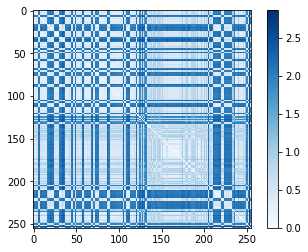

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
# visualizamos la matriz D
plt.imshow(pair_rmsd_pisani, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

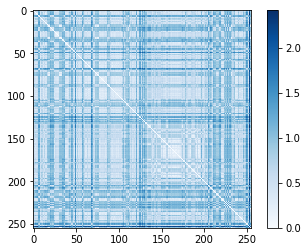

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
# visualizamos la matriz D
plt.imshow(pair_rmsd_pisani, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [28]:
# Función para verificar que la matriz sea simétrica ya que R no la identificó como tal
def is_symmetric(a):
    return np.allclose(a, a.T, atol=8)
is_symmetric(pair_rmsd_pisani)
# np.savetxt("rmsd_pariwise_pisani.csv", pair_rmsd_pisani, delimiter=",")

True

## Realizamos el MDS usando Sklearn: metric MDS

In [37]:
from sklearn.manifold import MDS

Usamos la clase MDS que recibe con los valores por defecto para realizar un MDS métrico. El método fit_transform recibe la matriz de RMSD por pares. Posteriormente, graficamos el resultado usando los mismo PDB IDs que Pisani usa en su gráfica de MDS.

In [315]:
seed = np.random.RandomState(seed=1)
mds_model = MDS(n_components = 2, dissimilarity = 'precomputed', metric = True)
mds_pisani_sk = mds_model.fit_transform( pair_rmsd_pisani )

In [38]:
def plot_pisani_mds(mds, titulo=""):
    '''Función para graficar el MDS de Pisiani'''
    col =  [ "red"   if i == '1fin_MODLL_ca' else 
             "cyan"    if i == '5a14_MODLL_ca' else 
             "blue"    if i == '4gcj_MODLL_ca' else 
             "green"   if i == '3pxr_MODLL_ca' else 
             "magenta" if i == '3pxf_MODLL_ca' else
             'None'    for i in ens_pisani.getLabels() ]
    fig = plt.figure(figsize=(7,7))
    plt.scatter( mds[:, 0], mds[:, 1], marker='o', c="lightsteelblue", alpha=0.7, s=30)
    plt.scatter( mds[:, 0], mds[:, 1], marker='o', c=col, s=70)
    plt.title(titulo,fontsize=18); plt.xlabel("Primer componente",fontsize=14); plt.ylabel("Segundo componente",fontsize=14)
    for color, label, x, y in zip(col, ens_pisani.getLabels(), mds[:, 0], mds[:, 1]):
        if color != 'None': plt.annotate(label.split("_")[0], xy = (x, y), fontsize=15)
    plt.axhline(0, color='grey',  linestyle='--')
    plt.axvline(0, color='grey',  linestyle='--')
    plt.axis('equal'); plt.grid();

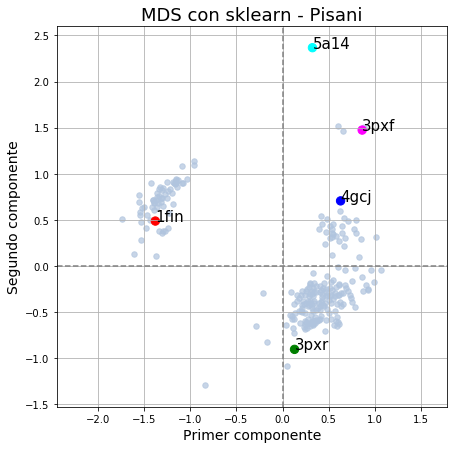

In [316]:
%matplotlib inline
plot_pisani_mds(mds_pisani_sk, "MDS con sklearn - Pisani")

Al comparar esta gráfica por la presentada por Pisani vemos que se puede distinguir una distribución similar en los puntos toamdno como referencia las estructuras representativas que Pisani usó. No obstante, la gráfica difiere y esto se debe a la imprementación del MDS por sklearn, que corresponde a un **Metric multidimensional scaling (mMDS)** el cual usa un método de minimización basado en un random_state estocástico. Esto se usa *para inicializar los centros*, lo que sea que eso signifique.

## Classical Multidimensional Scaling
Probamos utilizar las fórmulas que se muestran en el artículo de Pisiani.
MDS recibe una matriz $\Delta$, que es una matriz simétrica de distancias de dimensión $nxn$, donde $n$ es el número de puntos (conformaciones) en el conjunto de datos. Como resultado, devuelve una nueva matrix $\Lambda$ de $mxn$ dimensiones, done $m$ es el número de las nuevas dimensiones definidas por el usiario para proyectar los puntos. fuente: https://www.stat.pitt.edu/sungkyu/course/2221Fall13/lec8_mds_combined.pdf
#### Procedimiento
- Comenzamos con una matriz de distancias por pares (en este caso de valores de RMSD por par de conformaciones cristalográficas $i$ y $j$ ); la matriz $\Delta=[\delta_{ij}]$, donde $\delta_{ij} = RMSD(i,j)$.
- Se genera la matriz de distancias cuadradas, $\Delta_2=[\delta_{ij}^2]$, donde $\delta_{ij}^2 = [RMSD(i,j)]^2$.
- Double centering: La matriz $\Delta$ se centraliza utilizando una matriz de centrado (centering matrix) $J = I - \frac{1_n1_n^t}{n}$, donde $I$ es una matriz de identidad de $nxn$, y $1_n = (1_1,1_2...1_n)^t$, un vector de $unos$ de $1xn$ dimensiones. En Pisani (2016) se define a $J=I-\frac{m_n}{n}$, donde $m_n$ es una matriz de masas con $n$ vectores, si la masa es la misma para todos, todos los valores son $1$s.
- Se calcula la matriz de Gram $B$ a partir de la matriz de distancia $\Delta$ (aparentemente es posible calcularla a partir de los datos crudos cuando se mide una distancia ecuclidiana: $B=XX^T$):
    - Se aplica el "double centering" a $\Delta_2$: $B = \frac{1}{2}J\Delta_2J$
- Se calculan los $m$ eigenvalores ($\lambda_1, \lambda_2, ..., \lambda_m$) y eigenvectores ($e_1, e_2, ..., e_m$) de $B$ y se ordenan de mayor a menor.
- Se obtiene X mediante la *eigen-decomposition* de $B$. $X$ puede llegar a tener hasta $n$ dimensiones o $m$ dimensiones definidas por el usiario. Las primeras dimensiones (columnas) contienen la mayor variación entre las observaciones. $X_m$ se obtiene a partir de la sig. ecuación:
$$X_m = E_m\Lambda_m^{1/2} $$
Donde $E_m$ es una matrix de $nxm$ correspondeinte a los $m$ primeros eigenvectores. $\Lambda_m$ es la matriz diagonal de los $m$ eigenvalores de $B$.

#### Función para ejecutar el cMDS

In [29]:
from __future__ import division
import numpy as np
 
def cMDS(D):
    # Modificado de: http://www.nervouscomputer.com/hfs/cmdscale-in-python/
    # Número de observaciones                                                                
    n = len(D)
    # Se genera la matriz de distancia al cuadrado (Squared proximity matrix)
    D_sq = D**2
    # Se genera la matriz de  centrado J (Centering matrix)
    # Definida como la matriz de identidad In menos la matriz de nxn unos/n
    e1 = np.ones(n).reshape(n,1)
    m = ( np.ones(n).reshape(n, 1) / n)
    I = np.eye(n) # Matriz de identidad I_n
    J = I - e1.dot(np.transpose(m)) # Mariz de centrado
    # Se genera la matriz B, definida como B = -0.5*J*D^2*J                                                                                 
    B = -(1/2) * J.dot(D_sq).dot(J) # como J es simétrica da lo mismo teansponerla o no

    # Se determinan los eigenvalores y eigenvectores de la matriz B                                                                         
    e_vals, e_vecs = np.linalg.eigh(B)

    # Se ordenan los eigenvalores de mayor a menor
    idx   = np.argsort(e_vals)[::-1] # Se extraen los índices de ordenamiento
    e_vals = e_vals[idx] # Se ordena cada vector según el eigenvalor
    e_vecs = e_vecs[:,idx]
    w, = np.where(e_vals > 0) # Se seleccionan los índices donde los eValores son positivos
    e_vals = e_vals[w]
    # Se obtiene la matriz de configuración F = M^(-1/2)*E_m*L_m^(1/2)  
    M_neg_sq = np.diag(m[:,0]**(-0.5)) # M_neg_sq es la matriz M^(-1/2)
    L_m_sq  = np.diag(np.sqrt(e_vals[w])) #  Lambda_sq (L_m^(1/2)) es la matriz diagonal con la raiz cuadrada de m eigenValores positivos
    E_m = e_vecs[:,w] # E_m  es la matriz con los m eigenvectores positivos y ordenados
    # F  = M_neg_sq.dot(E_m.dot((L_m_sq)))  # F = M^(-1/2)*E_m*L_m^(1/2)
    F = E_m.dot((L_m_sq))
    #print(B == (X.transpose()).dot(X) )

    return F, D_sq, B, e_vals

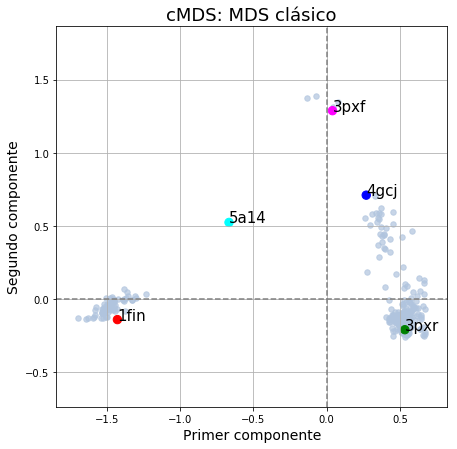

In [39]:
%matplotlib inline
mds_pisani_CMDS = cMDS(pair_rmsd_pisani)
plot_pisani_mds(mds_pisani_CMDS[0][:,0:2], "cMDS: MDS clásico")

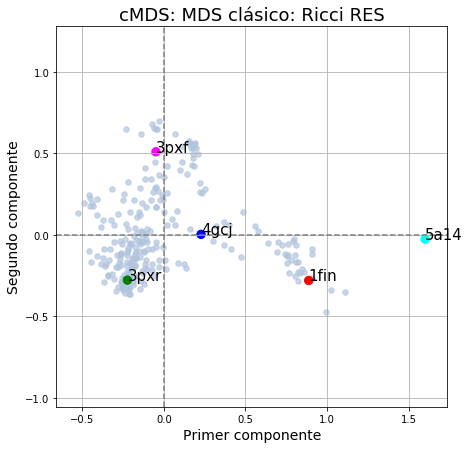

In [44]:
%matplotlib inline
mds_pisani_CMDS = cMDS(pair_rmsd_pisani)
plot_pisani_mds(mds_pisani_CMDS[0][:,0:2], "cMDS: MDS clásico: Ricci RES")

## The out sample problem
El problema de agregar un nuevo punto a la proyección, para ello probamos agregar una nueva estructura no incluida en las 255 usadas por Pisiani, en este caso usamos la estructura 1AQ1.

In [31]:
# Probamos con la estructura Inhibida 1AQ1
"1aq1" in cdk2_stc_Pisiani.index
# La estructura no está en las 255 elegidas por Pisani

False

In [274]:
strc_1fin = parsePDB("./../Modelos_Full_CDK2_PDB/1fin_full.pdb", subset = "ca").select('resnum ' + pisiani_residues_str)
print(calcCenter(strc_1fin))
matchAlign(strc_1fin, ref_strc_residues)
print(calcCenter(strc_1fin)) #Verificamos que el alineamiento haya tenido efecto

@> 298 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Checking AtomGroup 1fin_full_ca: 1 chains are identified
@> Checking AtomGroup 1fin_full_ca: 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain   from 1fin_full_ca (len=117) and Chain   from 1fin_full_ca (len=117):
@> 	Match: 117 residues match with 100% sequence identity and 100% overlap.
@> Alignment is based on 117 atoms matching 'calpha'.
@> Before alignment RMSD: 0.00
@> After alignment  RMSD: 0.00


[-18.41525641 211.19974359 113.17609402]
[-18.41525641 211.19974359 113.17609402]


In [275]:
# Calculamos el vector a de valores de RMSD de 1aq1 vs las 255 estructuras de Pisani
out_point_1fin = [calcRMSD(strc_1fin, ens_pisani.getConformation(x)) for x in range(0,len(ens_pisani))]
len(out_point_1fin)
# Convertimos en un arreglo
a = np.asanyarray([out_point_1fin])
shape(a)

(1, 255)

### Función para proyectar un nuevo punto
https://www.utdallas.edu/~herve/Abdi-MDS2007-pretty.pdf

In [276]:
def cMDS_proj(cMDS_obj, sup_point):
    # Recibe un objeto cMDS_obj
    F = cMDS_obj[0] # Matriz F de scores obtenida con cMDS a partir de los valores "Activos"
    D_sq = cMDS_obj[1] # Matrix Delta^2
    e_vals = cMDS_obj[3] # Eigenvalores positivos obtenidos del B de los valores "Activos"
    n = len(D_sq)
    e1 = np.ones(n).reshape(n,1)
    m = ( np.ones(n).reshape(n, 1) / n)
    I = np.eye(n) # Matriz de identidad I_n
    J = I - e1.dot(np.transpose(m)) # Mariz de centrado
    # MDS out-of-smaple: Adición de un punto suplementario
    a_out = sup_point**2
    # D_sup_2 es un vector con los valores de RMSD del nuevo punto frente a los "Activos"
    # Se calcula B_sup como -0.5*J*(a_out - D^2*(m1^t))
    B_sup = -0.5 *J.dot(a_out.reshape(n,1) - D_sq.dot(m.dot(np.transpose(e1))))
    # Finalmente se calcula F_sup = (B_sup^t)*F*L_inv
    # Donde L_inv es la matriz diagonal con la inversa de los eingenvalores
    L_m_inv = np.diag( 1 / e_vals )
    F_proj = np.transpose(B_sup).dot( F ).dot( L_m_inv)
    return F_proj

Pruebamos proyectar nuevamente la conformación 1fin como si fuese nueva

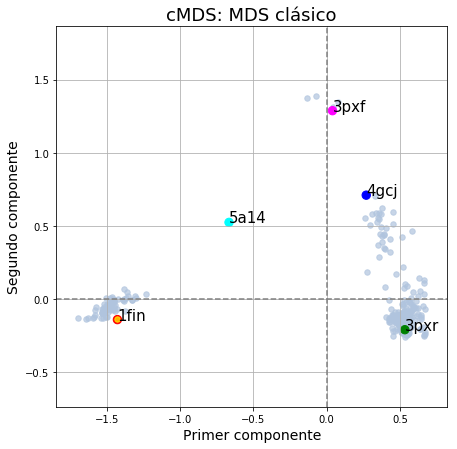

In [336]:
mds_pisani_CMDS = cMDS(pair_rmsd_pisani)
p = cMDS_proj(mds_pisani_CMDS, a)
plot_pisani_mds(mds_pisani_CMDS[0], "cMDS: MDS clásico")
plt.scatter( p[0, 0], p[0, 1], marker='o', c="yellow", alpha=0.7, s=30);

#### Preuba con una nueva estructura

In [282]:
def get_vect_out_point(pdbid):
    strc = parsePDB("./../Modelos_Full_CDK2_PDB/" + pdbid + "_full.pdb", subset = "ca").select('resnum ' + pisiani_residues_str)
    matchAlign(strc, ref_strc_residues)
    # Calculamos el vector a de valores de RMSD de 1aq1 vs las 255 estructuras de Pisani
    out_point = [calcRMSD(strc, ens_pisani.getConformation(x)) for x in range(0,len(ens_pisani))]
    a = np.asanyarray([out_point])
    return(a)

@> 298 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> Checking AtomGroup 1fq1_full_ca: 1 chains are identified
@> Checking AtomGroup 1fin_full_ca: 1 chains are identified
@> Trying to match chains based on residue numbers and names:
@>   Comparing Chain   from 1fq1_full_ca (len=117) and Chain   from 1fin_full_ca (len=117):
@> 	Match: 117 residues match with 100% sequence identity and 100% overlap.
@> Alignment is based on 117 atoms matching 'calpha'.
@> Before alignment RMSD: 1.14
@> After alignment  RMSD: 0.91


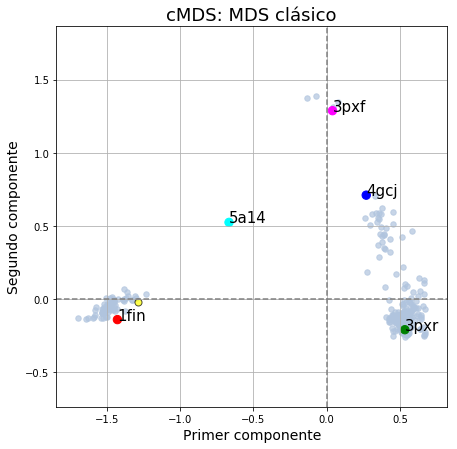

In [339]:
b = get_vect_out_point("1fq1")
q = cMDS_proj(mds_pisani_CMDS, b)
plot_pisani_mds(mds_pisani_CMDS[0], "cMDS: MDS clásico")
plt.scatter( q[0, 0], q[0, 1], marker='o',  edgecolor='black', c="yellow", alpha=0.7, s=50);

In [337]:
mol_con_atp = df_cdk2.NameLigs.apply(lambda x:  "ATP" in x)
mol_con_atp

PDB_ID
1aq1    False
1b38     True
1b39     True
1buh    False
1ckp    False
1di8    False
1dm2    False
1e1v    False
1e1x    False
1e9h    False
1f5q    False
1fin     True
1fq1     True
1fvt    False
1fvv    False
1g5s    False
1gih    False
1gii    False
1gij    False
1gy3     True
1gz8    False
1h00    False
1h01    False
1h07    False
1h08    False
1h0v    False
1h0w    False
1h1p    False
1h1q    False
1h1r    False
        ...  
5anj    False
5ank    False
5ano    False
5cyi    False
5d1j    False
5fp5    False
5fp6    False
5iev    False
5iex    False
5iey    False
5if1    False
5jq5    False
5jq8    False
5k4j    False
5l2w    False
5lmk    False
5nev    False
5oo0    False
5oo1    False
5oo3    False
5osj    False
5osm    False
5uq1    False
5uq2    False
6gub    False
6guc    False
6gue    False
6guf    False
6guh    False
6guk    False
Name: NameLigs, Length: 385, dtype: bool

In [331]:
X = np.array([1 ,2 ,3 , 4, 5, 6, 7, 8]).reshape(4,2)
X

array([[1, 2],
       [3, 4],
       [5, 6],
       [7, 8]])

In [333]:
def d(a,b):
    return np.transpose((a-b)).dot(a-b)

In [334]:
d(X[0,:], X[1,:])

8

In [326]:
X.dot(np.transpose(X))

array([[ 5, 10],
       [10, 20]])